__pip install duckdb__  Executing an SQL query over a pandas dataset

In [2]:
import pandas as pd
import numpy as np

### __Create and merge Dataframe__

In [4]:
# pass in column names for each CSV
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('ml-100k/u.user', sep='|', names=u_cols,
                    encoding='latin-1')

r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=r_cols,
                      encoding='latin-1')

# the movies file contains columns indicating the movie's genres
# let's only load the first five columns of the file with usecols
m_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
movies = pd.read_csv('ml-100k/u.item', sep='|', names=m_cols, usecols=range(5),
                     encoding='latin-1')

# create one merged DataFrame
movie_ratings = pd.merge(movies, ratings)
lens = pd.merge(movie_ratings, users)


In [15]:
# in columns để dễ hình dung về dataframe
print(users.columns)
print(ratings.columns)
print(movies.columns)
print(lens.columns)

Index(['user_id', 'age', 'sex', 'occupation', 'zip_code'], dtype='object')
Index(['user_id', 'movie_id', 'rating', 'unix_timestamp'], dtype='object')
Index(['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url'], dtype='object')
Index(['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url',
       'user_id', 'rating', 'unix_timestamp', 'age', 'sex', 'occupation',
       'zip_code'],
      dtype='object')


In [19]:
lens.head(3)

,movie_id,title,release_date,video_release_date,imdb_url,user_id,rating,unix_timestamp,age,sex,occupation,zip_code
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,308,4,887736532,60,M,retired,95076
1,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,308,5,887737890,60,M,retired,95076
2,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),308,4,887739608,60,M,retired,95076


### __What are the 25 most rated movies?__

__Cach 1__

In [ ]:
most_rated = lens.groupby('title').size().sort_values(ascending=False)[:25]
most_rated

There's a lot going on in the code above, but it's very idomatic. We're splitting the DataFrame into groups by movie title and applying the size method to get the count of records in each group. Then we order our results in descending order and limit the output to the top 25 using Python's slicing syntax.

__Cach 2__

In [ ]:
lens.title.value_counts()[:25]

__Cach 3: Use sql command in pandas dataframe__

In [7]:
import duckdb
duckdb.query("SELECT * FROM users limit 10").df() # returns a result dataframe

,user_id,age,sex,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213
5,6,42,M,executive,98101
6,7,57,M,administrator,91344
7,8,36,M,administrator,05201
8,9,29,M,student,01002
9,10,53,M,lawyer,90703


In [24]:
duckdb.query("SELECT title, count(1) FROM lens GROUP BY title ORDER BY 2 DESC LIMIT 25")

┌───────────────────────────────────────────┬──────────┐
│                   title                   │ count(1) │
│                  varchar                  │  int64   │
├───────────────────────────────────────────┼──────────┤
│ Star Wars (1977)                          │      583 │
│ Contact (1997)                            │      509 │
│ Fargo (1996)                              │      508 │
│ Return of the Jedi (1983)                 │      507 │
│ Liar Liar (1997)                          │      485 │
│ English Patient, The (1996)               │      481 │
│ Scream (1996)                             │      478 │
│ Toy Story (1995)                          │      452 │
│ Air Force One (1997)                      │      431 │
│ Independence Day (ID4) (1996)             │      429 │
│          ·                                │       ·  │
│          ·                                │       ·  │
│          ·                                │       ·  │
│ Jerry Maguire (1996)         

### __Which movies are most highly rated?__

___Cach 1__

In [41]:
movie_stats = lens.groupby('title').agg({'rating': [np.size, np.mean]})
movie_stats.head()

rating          
                            size      mean
title                                     
'Til There Was You (1997)      9  2.333333
1-900 (1994)                   5  2.600000
101 Dalmatians (1996)        109  2.908257
12 Angry Men (1957)          125  4.344000
187 (1997)                    41  3.024390

In [42]:
movie_stats.sort_values([('rating', 'mean')], ascending=False).head()

rating     
                                             size mean
title                                                 
They Made Me a Criminal (1939)                  1  5.0
Marlene Dietrich: Shadow and Light (1996)       1  5.0
Saint of Fort Washington, The (1993)            2  5.0
Someone Else's America (1995)                   1  5.0
Star Kid (1997)                                 3  5.0

In [43]:
atleast_100 = movie_stats['rating']['size'] >= 100
movie_stats[atleast_100].sort_values([('rating', 'mean')], ascending=False)[:15]

rating          
                                         size      mean
title                                                  
Close Shave, A (1995)                     112  4.491071
Schindler's List (1993)                   298  4.466443
Wrong Trousers, The (1993)                118  4.466102
Casablanca (1942)                         243  4.456790
Shawshank Redemption, The (1994)          283  4.445230
Rear Window (1954)                        209  4.387560
Usual Suspects, The (1995)                267  4.385768
Star Wars (1977)                          583  4.358491
12 Angry Men (1957)                       125  4.344000
Citizen Kane (1941)                       198  4.292929
To Kill a Mockingbird (1962)              219  4.292237
One Flew Over the Cuckoo's Nest (1975)    264  4.291667
Silence of the Lambs, The (1991)          390  4.289744
North by Northwest (1959)                 179  4.284916
Godfather, The (1972)                     413  4.283293

__Cach 2__ The SQL equivalent would be:

In [59]:
duckdb.query("SELECT title, COUNT(1) size, AVG(rating) mean FROM lens GROUP BY title HAVING COUNT(1) >= 100 ORDER BY 3 DESC LIMIT 15;")

┌────────────────────────────────────────┬───────┬────────────────────┐
│                 title                  │ size  │        mean        │
│                varchar                 │ int64 │       double       │
├────────────────────────────────────────┼───────┼────────────────────┤
│ Close Shave, A (1995)                  │   112 │  4.491071428571429 │
│ Schindler's List (1993)                │   298 │  4.466442953020135 │
│ Wrong Trousers, The (1993)             │   118 │  4.466101694915254 │
│ Casablanca (1942)                      │   243 │   4.45679012345679 │
│ Shawshank Redemption, The (1994)       │   283 │  4.445229681978798 │
│ Rear Window (1954)                     │   209 │ 4.3875598086124405 │
│ Usual Suspects, The (1995)             │   267 │  4.385767790262173 │
│ Star Wars (1977)                       │   583 │ 4.3584905660377355 │
│ 12 Angry Men (1957)                    │   125 │              4.344 │
│ Citizen Kane (1941)                    │   198 │  4.2929292929

### __Limiting our population going forward__

In [61]:
# let's only look at the 50 most rated movies
most_50 = lens.groupby('movie_id').size().sort_values(ascending=False)[:50]
most_50

movie_id
50     583
258    509
100    508
181    507
294    485
286    481
288    478
1      452
300    431
121    429
174    420
127    413
56     394
7      392
98     390
237    384
117    378
172    367
222    365
313    350
204    350
405    344
79     336
210    331
151    326
173    324
69     321
748    316
168    316
269    315
257    303
195    301
423    300
9      299
276    298
318    298
22     297
302    297
328    295
96     295
25     293
118    293
15     293
183    291
216    290
176    284
64     283
202    280
234    280
191    276
dtype: int64

In [64]:
# sd sql
duckdb.query("CREATE TABLE IF NOT EXISTS most_50 AS ( SELECT movie_id, COUNT(1) FROM lens GROUP BY movie_id ORDER BY 2 DESC LIMIT 50 )")
duckdb.query("SELECT * FROM lens WHERE EXISTS (SELECT 1 FROM most_50 WHERE lens.movie_id = most_50.movie_id)")

┌──────────┬──────────────────────┬──────────────┬────────────────────┬───┬───────┬─────────┬────────────┬──────────┐
│ movie_id │        title         │ release_date │ video_release_date │ … │  age  │   sex   │ occupation │ zip_code │
│  int64   │       varchar        │   varchar    │       double       │   │ int64 │ varchar │  varchar   │ varchar  │
├──────────┼──────────────────────┼──────────────┼────────────────────┼───┼───────┼─────────┼────────────┼──────────┤
│        1 │ Toy Story (1995)     │ 01-Jan-1995  │               NULL │ … │    60 │ M       │ retired    │ 95076    │
│        7 │ Twelve Monkeys (19…  │ 01-Jan-1995  │               NULL │ … │    60 │ M       │ retired    │ 95076    │
│        9 │ Dead Man Walking (…  │ 01-Jan-1995  │               NULL │ … │    60 │ M       │ retired    │ 95076    │
│       15 │ Mr. Holland's Opus…  │ 29-Jan-1996  │               NULL │ … │    60 │ M       │ retired    │ 95076    │
│       22 │ Braveheart (1995)    │ 16-Feb-1996  │      

### __Which movies are most controversial amongst different ages?__

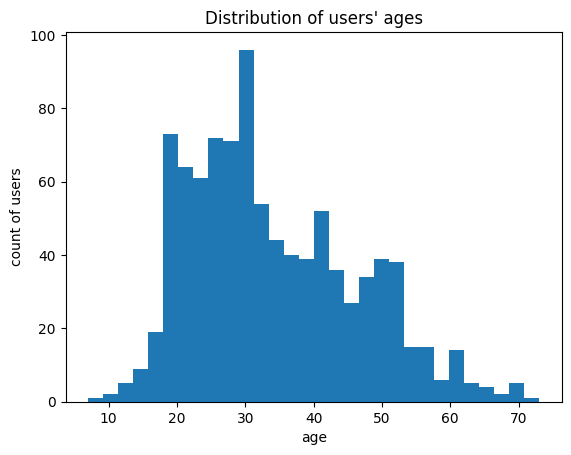

In [66]:
import matplotlib.pyplot as plt
users.age.plot.hist(bins=30)
plt.title("Distribution of users' ages")
plt.ylabel('count of users')
plt.xlabel('age');

### __Binning our users__

In [67]:
labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79']
lens['age_group'] = pd.cut(lens.age, range(0, 81, 10), right=False, labels=labels)
lens[['age', 'age_group']].drop_duplicates()[:10]

,age,age_group
0,60,60-69
397,21,20-29
459,33,30-39
524,30,30-39
782,23,20-29
995,29,20-29
1229,26,20-29
1664,31,30-39
1942,24,20-29
2270,32,30-39


In [68]:
lens.groupby('age_group').agg({'rating': [np.size, np.mean]})


rating          
            size      mean
age_group                 
0-9           43  3.767442
10-19       8181  3.486126
20-29      39535  3.467333
30-39      25696  3.554444
40-49      15021  3.591772
50-59       8704  3.635800
60-69       2623  3.648875
70-79        197  3.649746

In [69]:
lens.set_index('movie_id', inplace=True)
by_age = lens.loc[most_50.index].groupby(['title', 'age_group'])
by_age.rating.mean().head(15)

title                 age_group
Air Force One (1997)  0-9               NaN
                      10-19        3.647059
                      20-29        3.666667
                      30-39        3.570000
                      40-49        3.555556
                      50-59        3.750000
                      60-69        3.666667
                      70-79        3.666667
Alien (1979)          0-9               NaN
                      10-19        4.111111
                      20-29        4.026087
                      30-39        4.103448
                      40-49        3.833333
                      50-59        4.272727
                      60-69        3.500000
Name: rating, dtype: float64

In [70]:
by_age.rating.mean().unstack(1).fillna(0)[10:20]

age_group,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79
title,,,,,,,,
E.T. the Extra-Terrestrial (1982),0.0,3.680000,3.609091,3.806818,4.160000,4.368421,4.375000,0.000000
"Empire Strikes Back, The (1980)",4.0,4.642857,4.311688,4.052083,4.100000,3.909091,4.250000,5.000000
"English Patient, The (1996)",5.0,3.739130,3.571429,3.621849,3.634615,3.774648,3.904762,4.500000
Fargo (1996),0.0,3.937500,4.010471,4.230769,4.294118,4.442308,4.000000,4.333333
Forrest Gump (1994),5.0,4.047619,3.785714,3.861702,3.847826,4.000000,3.800000,0.000000
"Fugitive, The (1993)",0.0,4.320000,3.969925,3.981481,4.190476,4.240000,3.666667,0.000000
"Full Monty, The (1997)",0.0,3.421053,4.056818,3.933333,3.714286,4.146341,4.166667,3.500000
"Godfather, The (1972)",0.0,4.400000,4.345070,4.412844,3.929412,4.463415,4.125000,0.000000
Groundhog Day (1993),0.0,3.476190,3.798246,3.786667,3.851064,3.571429,3.571429,4.000000


In [71]:
by_age.rating.mean().unstack(0).fillna(0)

title,Air Force One (1997),Alien (1979),Aliens (1986),Amadeus (1984),Back to the Future (1985),"Birdcage, The (1996)",Braveheart (1995),Conspiracy Theory (1997),Contact (1997),Dead Man Walking (1995),...,Star Trek: First Contact (1996),Star Wars (1977),Terminator 2: Judgment Day (1991),"Terminator, The (1984)",Titanic (1997),Toy Story (1995),Twelve Monkeys (1995),Twister (1996),When Harry Met Sally... (1989),Willy Wonka and the Chocolate Factory (1971)
age_group,,,,,,,,,,,,,,,,,,,,,
0-9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,...,0.000000,3.000000,0.000000,0.000000,5.000000,0.000000,4.000000,0.000000,0.000000,0.000000
10-19,3.647059,4.111111,4.050000,4.250000,4.037037,3.217391,4.384615,3.565217,3.693878,3.647059,...,3.576923,4.630435,4.173913,3.619048,4.611111,3.621622,3.916667,3.000000,3.500000,3.387097
20-29,3.666667,4.026087,4.087719,4.067308,3.720588,3.413223,4.194915,3.382114,3.785714,3.926606,...,3.641975,4.413043,3.969466,3.875969,4.336066,3.920635,3.847458,3.200000,4.000000,3.820144
30-39,3.570000,4.103448,3.887640,4.236842,3.915789,3.514286,4.156627,3.419355,3.847458,3.814286,...,3.737864,4.305732,3.977011,4.105882,4.236111,4.033058,3.788462,3.133333,3.882353,3.908046
40-49,3.555556,3.833333,3.526316,4.081633,4.036364,3.500000,4.051282,3.465116,3.866667,3.754386,...,3.760000,4.166667,4.212121,3.975610,3.984848,3.700000,3.653846,3.479167,3.825000,3.058824
50-59,3.750000,4.272727,4.235294,4.230769,3.500000,3.346154,3.956522,3.538462,3.739130,4.294118,...,3.272727,4.469388,3.941176,3.900000,4.210526,3.758621,3.650000,3.300000,3.904762,2.857143
60-69,3.666667,3.500000,3.800000,4.750000,3.857143,3.888889,3.714286,2.600000,3.777778,4.000000,...,3.000000,4.000000,3.500000,3.600000,3.846154,3.400000,3.000000,3.250000,3.800000,3.000000
70-79,3.666667,4.000000,3.000000,5.000000,4.000000,0.000000,4.000000,0.000000,0.000000,0.000000,...,5.000000,4.000000,0.000000,0.000000,4.000000,5.000000,0.000000,0.000000,4.500000,0.000000


### __Which movies do men and women most disagree on?__

In [72]:
duckdb.query("SELECT title, AVG(IF(sex = 'F', rating, NULL)), AVG(IF(sex = 'M', rating, NULL)) FROM lens GROUP BY title")

┌──────────────────────┬───────────────────────────────────┬───────────────────────────────────────────────────────────┐
│        title         │ avg(CASE  WHEN ((sex = 'F')) TH…  │ avg(CASE  WHEN ((sex = 'M')) THEN (rating) ELSE NULL END) │
│       varchar        │              double               │                          double                           │
├──────────────────────┼───────────────────────────────────┼───────────────────────────────────────────────────────────┤
│ Toy Story (1995)     │                3.7899159663865545 │                                          3.90990990990991 │
│ Get Shorty (1995)    │                               3.4 │                                         3.591463414634146 │
│ Copycat (1995)       │                 3.772727272727273 │                                                  3.140625 │
│ Twelve Monkeys (19…  │                3.5609756097560976 │                                         3.861290322580645 │
│ Babe (1995)          │        

In [73]:
lens.reset_index('movie_id', inplace=True)
pivoted = lens.pivot_table(index=['movie_id', 'title'],
                           columns=['sex'],
                           values='rating',
                           fill_value=0)
pivoted.head()

,sex,F,M
movie_id,title,,
1,Toy Story (1995),3.789916,3.909910
2,GoldenEye (1995),3.368421,3.178571
3,Four Rooms (1995),2.687500,3.108108
4,Get Shorty (1995),3.400000,3.591463
5,Copycat (1995),3.772727,3.140625


In [74]:
pivoted['diff'] = pivoted.M - pivoted.F
pivoted.head()

,sex,F,M,diff
movie_id,title,,,
1,Toy Story (1995),3.789916,3.909910,0.119994
2,GoldenEye (1995),3.368421,3.178571,-0.189850
3,Four Rooms (1995),2.687500,3.108108,0.420608
4,Get Shorty (1995),3.400000,3.591463,0.191463
5,Copycat (1995),3.772727,3.140625,-0.632102


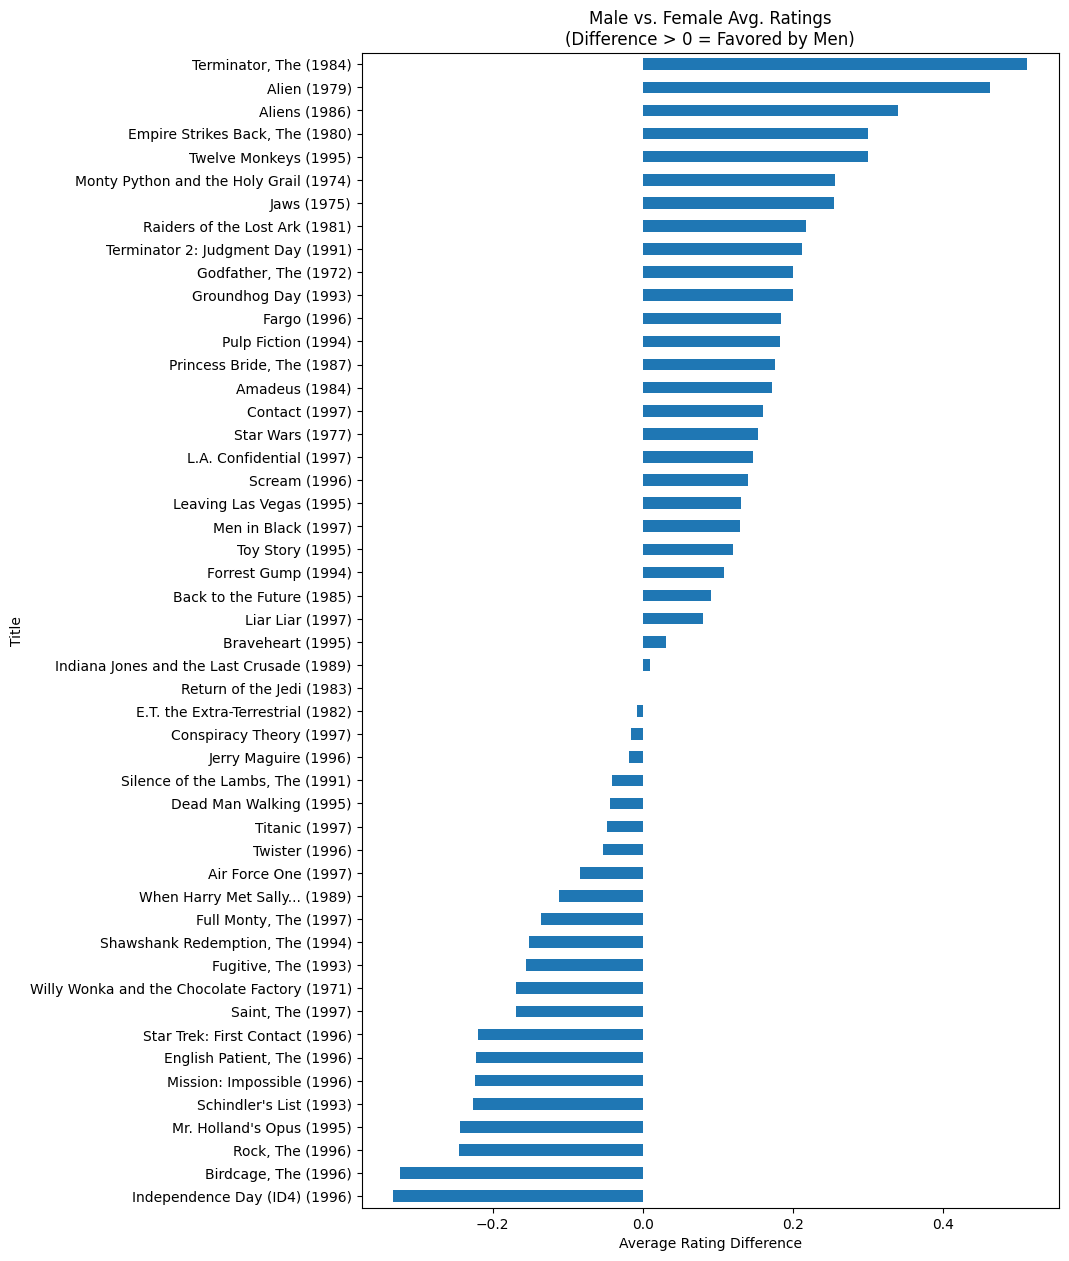

In [75]:
pivoted.reset_index('movie_id', inplace=True)
disagreements = pivoted[pivoted.movie_id.isin(most_50.index)]['diff']
disagreements.sort_values().plot(kind='barh', figsize=[9, 15])
plt.title('Male vs. Female Avg. Ratings\n(Difference > 0 = Favored by Men)')
plt.ylabel('Title')
plt.xlabel('Average Rating Difference');

## BASIC


__ASCII / ISO 8859-1 (Latin-1) Table with HTML Entity Names__
https://cs.stanford.edu/people/miles/iso8859.html

### panda merge

__Merging two Dataframe with same number of elements :__

In [8]:
# creating the first DataFrame
df1 = pd.DataFrame({"fruit" : ["apple", "banana", "avocado"],
                    "market_price" : [21, 14, 35]})
display("The first DataFrame")
display(df1)
  
# creating the second DataFrame
df2 = pd.DataFrame({"fruit" : ["banana", "apple", "avocado"],
                    "wholesaler_price" : [65, 68, 75]})
display("The second DataFrame")
display(df2)
  
# joining the DataFrames
display("The merged DataFrame")
pd.merge(df1, df2, on = "fruit", how = "inner")

'The first DataFrame'

,fruit,market_price
0,apple,21
1,banana,14
2,avocado,35


'The second DataFrame'

,fruit,wholesaler_price
0,banana,65
1,apple,68
2,avocado,75


'The merged DataFrame'

,fruit,market_price,wholesaler_price
0,apple,21,68
1,banana,14,65
2,avocado,35,75


__Merging two Dataframe with different number of elements__

In [9]:
df1 = pd.DataFrame({"fruit" : ["apple", "banana", 
                               "avocado", "grape"],
                    "market_price" : [21, 14, 35, 38]})
display("The first DataFrame")
display(df1)
  
# creating the second DataFrame
df2 = pd.DataFrame({"fruit" : ["apple", "banana", "grape"],
                    "wholesaler_price" : [65, 68, 71]})
display("The second DataFrame")
display(df2)
  
# joining the DataFrames
# here both common DataFrame elements are in df1 and df2, 
# so it extracts apple, banana, grapes from df1 and df2.  
display("The merged DataFrame")
pd.merge(df1, df2, on = "fruit", how = "inner")

'The first DataFrame'

,fruit,market_price
0,apple,21
1,banana,14
2,avocado,35
3,grape,38


'The second DataFrame'

,fruit,wholesaler_price
0,apple,65
1,banana,68
2,grape,71


'The merged DataFrame'

,fruit,market_price,wholesaler_price
0,apple,21,65
1,banana,14,68
2,grape,38,71


In [10]:
# use how = outer
pd.merge(df1, df2, on = "fruit", how = "outer")

,fruit,market_price,wholesaler_price
0,apple,21,65.0
1,banana,14,68.0
2,avocado,35,NaN
3,grape,38,71.0


In [11]:
# use how = left
pd.merge(df1, df2, on = "fruit", how = "left")

,fruit,market_price,wholesaler_price
0,apple,21,65.0
1,banana,14,68.0
2,avocado,35,NaN
3,grape,38,71.0


In [12]:
# use how = left
pd.merge(df1, df2, on = "fruit", how = "right")

,fruit,market_price,wholesaler_price
0,apple,21,65
1,banana,14,68
2,grape,38,71


### pandas size - pandas groupby size

In [18]:
df = pd.DataFrame({'col1': [1, 2], 'col2': [3, 4]})
display(df)
df.size


,col1,col2
0,1,3
1,2,4


4

In [20]:
df = pd.DataFrame({'team': ['A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B'],
                   'position': ['G', 'G', 'F', 'F', 'F', 'G', 'G', 'G', 'G', 'F'],
                   'points': [15, 22, 24, 25, 20, 35, 34, 19, 14, 12]})

#view DataFrame
print(df)

  team position  points
0    A        G      15
1    A        G      22
2    A        F      24
3    A        F      25
4    A        F      20
5    B        G      35
6    B        G      34
7    B        G      19
8    B        G      14
9    B        F      12


In [21]:
df.groupby('team').size()

team
A    5
B    5
dtype: int64

In [22]:
#count occurrences of values for each combination of team and position
df.groupby(['team', 'position']).size()


team  position
A     F           3
      G           2
B     F           1
      G           4
dtype: int64

In [23]:
#count occurrences for each combination of team and position and sort
df.groupby(['team', 'position']).size().sort_values(ascending=False)

team  position
B     G           4
A     F           3
      G           2
B     F           1
dtype: int64

### pandas Group and Aggregate

__Group by Two Columns and Find Average__

In [27]:
df = pd.DataFrame({'team': ['A', 'B', 'B', 'B', 'B', 'M', 'M', 'M'],
                   'position': ['G', 'G', 'F', 'G', 'F', 'F', 'C', 'C'],
                   'assists': [5, 7, 7, 8, 5, 7, 6, 9],
                   'rebounds': [11, 8, 10, 6, 6, 9, 6, 10]})

df

,team,position,assists,rebounds
0,A,G,5,11
1,B,G,7,8
2,B,F,7,10
3,B,G,8,6
4,B,F,5,6
5,M,F,7,9
6,M,C,6,6
7,M,C,9,10


In [28]:
df.groupby(['team', 'position']).agg({'assists': ['mean']}).reset_index()

,team,position,assists
,,,mean
0,A,G,5.0
1,B,F,6.0
2,B,G,7.5
3,M,C,7.5
4,M,F,7.0


In [29]:
#group by team and position and find mean assists
new = df.groupby(['team', 'position']).agg({'assists': ['mean']}).reset_index()

#rename columns 
new.columns = ['team', 'pos', 'mean_assists']

#view DataFrame
print(new)

  team pos  mean_assists
0    A   G           5.0
1    B   F           6.0
2    B   G           7.5
3    M   C           7.5
4    M   F           7.0


__Group by Two Columns and Find Multiple Stats__

In [31]:
df = pd.DataFrame({'team': ['A', 'B', 'B', 'B', 'B', 'M', 'M', 'M'],
                   'position': ['G', 'G', 'F', 'G', 'F', 'F', 'C', 'C'],
                   'assists': [5, 7, 7, 8, 5, 7, 6, 9],
                   'rebounds': [11, 8, 10, 6, 6, 9, 6, 10]})
df

,team,position,assists,rebounds
0,A,G,5,11
1,B,G,7,8
2,B,F,7,10
3,B,G,8,6
4,B,F,5,6
5,M,F,7,9
6,M,C,6,6
7,M,C,9,10


In [32]:
# find the median and max number of rebounds, grouped on columns ‘team’ and ‘position’:
df.groupby(['team', 'position']).agg({'rebounds': ['median', 'max']}).reset_index()

team position rebounds    
                  median max
0    A        G     11.0  11
1    B        F      8.0  10
2    B        G      7.0   8
3    M        C      8.0  10
4    M        F      9.0   9

__Aggregate using one or more operations over the specified axis.__

__VD1__

In [33]:
df = pd.DataFrame(
    {
        "A": [1, 1, 2, 2],
        "B": [1, 2, 3, 4],
        "C": [0.362838, 0.227877, 1.267767, -0.562860],
    }
)
df

,A,B,C
0,1,1,0.362838
1,1,2,0.227877
2,2,3,1.267767
3,2,4,-0.562860


In [34]:
# The aggregation is for each column.
df.groupby('A').agg('min')

,B,C
A,,
1,1,0.227877
2,3,-0.562860


In [36]:
# Multiple aggregations
df.groupby('A').agg(['min', 'max'])

B             C          
  min max       min       max
A                            
1   1   2  0.227877  0.362838
2   3   4 -0.562860  1.267767

In [37]:
# Select a column for aggregation
df.groupby('A').B.agg(['min', 'max'])

,min,max
A,,
1,1,2
2,3,4


In [38]:
# User-defined function for aggregation
df.groupby('A').agg(lambda x: sum(x) + 2)

,B,C
A,,
1,5,2.590715
2,9,2.704907


In [39]:
# Different aggregations per column
df.groupby('A').agg({'B': ['min', 'max'], 'C': 'sum'})

B             C
  min max       sum
A                  
1   1   2  0.590715
2   3   4  0.704907

In [40]:
# To control the output names with different aggregations per column, pandas supports “named aggregation”
df.groupby("A").agg(
    b_min=pd.NamedAgg(column="B", aggfunc="min"),
    c_sum=pd.NamedAgg(column="C", aggfunc="sum"))

,b_min,c_sum
A,,
1,1,0.590715
2,3,0.704907


__VD2__

In [3]:
df = pd.DataFrame([[1, 2, 3],
                   [4, 5, 6],
                   [7, 8, 9],
                   [np.nan, np.nan, np.nan]],
                  columns=['A', 'B', 'C'])
df

,A,B,C
0,1.0,2.0,3.0
1,4.0,5.0,6.0
2,7.0,8.0,9.0
3,NaN,NaN,NaN


In [4]:
# Aggregate different functions over the columns and rename the index of the resulting DataFrame
df.agg(x=('A', max), y=('B', 'min'), z=('C', np.mean))

,A,B,C
x,7.0,NaN,NaN
y,NaN,2.0,NaN
z,NaN,NaN,6.0


In [5]:
# Aggregate over the columns.
df.agg("mean", axis="columns")

0    2.0
1    5.0
2    8.0
3    NaN
dtype: float64

__VD3__

In [8]:
s = pd.Series([1,2,3,4,5],
                index=pd.date_range('20130101',
                                    periods=5,freq='s'))
s

2013-01-01 00:00:00    1
2013-01-01 00:00:01    2
2013-01-01 00:00:02    3
2013-01-01 00:00:03    4
2013-01-01 00:00:04    5
Freq: S, dtype: int64

In [10]:
r = s.resample('2s')
r

In [11]:
r.agg(np.sum)

2013-01-01 00:00:00    3
2013-01-01 00:00:02    7
2013-01-01 00:00:04    5
Freq: 2S, dtype: int64

In [12]:
r.agg(['sum','mean','max'])

,sum,mean,max
2013-01-01 00:00:00,3,1.5,2
2013-01-01 00:00:02,7,3.5,4
2013-01-01 00:00:04,5,5.0,5


In [13]:
r.agg({'result' : lambda x: x.mean() / x.std(),'total' : np.sum})

,result,total
2013-01-01 00:00:00,2.121320,3
2013-01-01 00:00:02,4.949747,7
2013-01-01 00:00:04,NaN,5
